In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from utils.utils import *

In [2]:
G = ox.load_graphml("data/osmnx/graph.graphml")

In [3]:
graph_nodes, graph_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Match GPS data to map

In [4]:
public_gps_df = pd.read_csv("data/public/public_gps_traces_bbox.csv")

In [5]:
nearest_edges, dists = ox.nearest_edges(G, public_gps_df["longitude"], public_gps_df["latitude"], return_dist=True, interpolate=metres_to_dist(INTERPOLATION_DIST_NEAREST_EDGE))

In [6]:
public_gps_df["ne"] = nearest_edges
public_gps_df["dist"] = dists

In [46]:
matched_public_gps_df = threshold_on_col(public_gps_df) # SEE TODO

In [38]:
test = matched_public_gps_df[matched_public_gps_df.groupby(["trackid", "tracksegid"])["dist"].transform('count') > 50].copy().sort_values(by=["tracksegid"])

In [29]:
test.groupby(["trackid", "tracksegid"]).count().sort_values(by=["dist"])

index  latitude  longitude    ne  dist
trackid tracksegid                                        
2017    1263           51        51         51    51    51
        850            51        51         51    51    51
7682    0              53        53         53    53    53
2017    1018           53        53         53    53    53
5755    0              53        53         53    53    53
...                   ...       ...        ...   ...   ...
2362    0            1301      1301       1301  1301  1301
782     0            1378      1378       1378  1378  1378
1659    0            1853      1853       1853  1853  1853
2546    0            2680      2680       2680  2680  2680
780     0            4302      4302       4302  4302  4302

[230 rows x 5 columns]

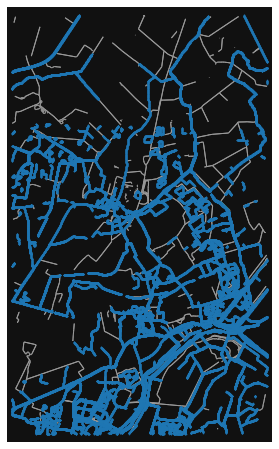

In [8]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(public_gps_df["longitude"], public_gps_df["latitude"], s=2, marker='.')
plt.show()

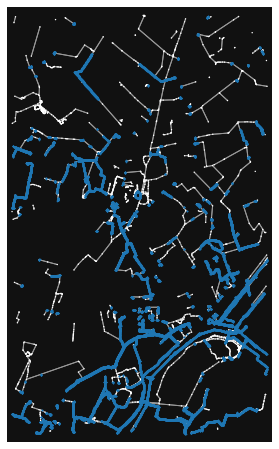

In [30]:
fig, ax = ox.plot_graph(G, node_size=2, show=False, close=False)
ax.scatter(matched_public_gps_df["longitude"], matched_public_gps_df["latitude"], s=2, marker='.')
plt.show()

(array([10955.,  7184., 16808.,  5349.,  5948.,  3990.,  3225.,  1313.,
         2859.,   333.]),
 array([52.327611  , 52.33758668, 52.34756237, 52.35753805, 52.36751373,
        52.37748942, 52.3874651 , 52.39744078, 52.40741647, 52.41739215,
        52.42736783]),
 <BarContainer object of 10 artists>)

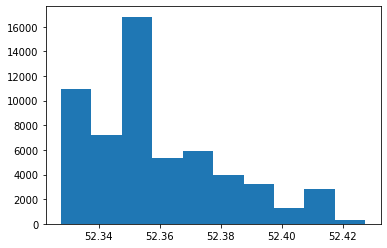

In [33]:
plt.hist(test["latitude"])

In [39]:
test

,index,latitude,longitude,tracksegid,trackid,ne,dist
0,208,52.349762,0.048696,0,673,"(8857288593, 8857288590, 0)",19.161540
47583,158482,52.331664,-0.018419,0,2546,"(1397397474, 1397397479, 0)",2.614047
47582,158481,52.331657,-0.018375,0,2546,"(1397397474, 1397397479, 0)",2.441159
47581,158480,52.331656,-0.018330,0,2546,"(1397397479, 1397397474, 0)",2.780783
47580,158479,52.331655,-0.018285,0,2546,"(1397397474, 1397397479, 0)",3.174999
...,...,...,...,...,...,...,...
31386,95336,52.364464,0.041414,1280,2017,"(4564837932, 4564837933, 0)",7.281588
31385,95335,52.364472,0.041458,1280,2017,"(4564837934, 4564837933, 0)",5.743835
31384,95334,52.364445,0.041492,1280,2017,"(4564837929, 4564837934, 0)",5.220281
31382,95332,52.364368,0.041498,1280,2017,"(4564837934, 4564837929, 0)",7.949029


In [42]:
test2 = test.loc[test["longitude"] < -0.03]
test2 = test2.loc[test2["latitude"].between(52.34, 52.38)]

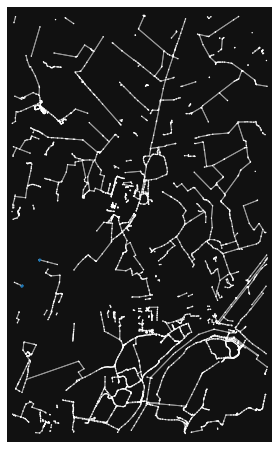

In [43]:
fig, ax = ox.plot_graph(G, node_size=2, show=False, close=False)
ax.scatter(test2["longitude"], test2["latitude"], s=2, marker='.')
plt.show()

In [47]:
matched_graph_edges_public = match_nearest_edges(graph_edges, matched_public_gps_df)

In [48]:
matched_graph_edges_public = matched_graph_edges_public.assign(activity=matched_graph_edges_public["tracks"])

In [60]:
matched_graph_edges_public = matched_graph_edges_public \
                                .loc[matched_graph_edges_public["count"] > matched_graph_edges_public["length"] / THRESH_EDGE_MAX_POINT_SEPARATION_PUBLIC_GPS] \
                                .drop(columns=["count", "tracks"])

In [12]:
matched_graph_edges_public.to_file("analysis_saves/matched_graph_edges_public.shp")

<ipython-input-12-aa557639ab6e>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  matched_graph_edges_public.to_file("analysis_saves/matched_graph_edges_public.shp")


In [62]:
G_match_public = ox.graph_from_gdfs(graph_nodes, matched_graph_edges_public)

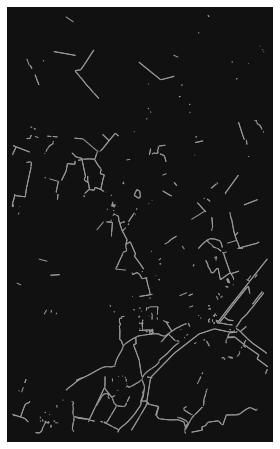

In [71]:
fig, ax = ox.plot_graph(G_match_public, node_size=0)

In [53]:
import networkx as nx

In [93]:
G_test = G_match_public.to_undirected()

In [94]:
ox.graph_to_gdfs(G_test, nodes=False, edges=True)

osmid                    name  highway  oneway  \
u          v          key                                                       
569438     1146879751 0     99149966  High Fen Crooked Drove    track   False   
76594398   3722037676 0     15016491        Long Holme Drove    track   False   
           8302739478 0     15016491        Long Holme Drove    track   False   
3722037676 1751709332 0     15016491        Long Holme Drove    track   False   
8302739478 148185286  0     15016491        Long Holme Drove    track   False   
...                              ...                     ...      ...     ...   
9579092886 9579092887 0    441162903                     NaN  footway   False   
9579092888 9579092889 0    441162903                     NaN  footway   False   
9579092889 9579092890 0    441162903                     NaN  footway   False   
9579092890 9579092891 0    441162903                     NaN  footway   False   
9579092891 9579092892 0    441162903                     NaN  footway   False   

                           reversed   length  \
u          v          key                      
569438     1146879751 0        True  582.359   
76594398   3722037676 0        True   48.977   
           8302739478 0       False   27.089   
3722037676 1751709332 0        True   65.319   
8302739478 148185286  0       False   66.800   
...                             ...      ...   
9579092886 9579092887 0        True   17.677   
9579092888 9579092889 0        True   10.047   
9579092889 9579092890 0        True    7.935   
9579092890 9579092891 0       False    9.193   
9579092891 9579092892 0        True   10.944   

                                                                    geometry  \
u          v          key                                                      
569438     1146879751 0    LINESTRING (-0.01790 52.41766, -0.02635 52.41857)   
76594398   3722037676 0      LINESTRING (0.02623 52.33005, 0.02591 52.32965)   
           8302739478 0      LINESTRING (0.02574 52.32943, 0.02591 52.32965)   
3722037676 1751709332 0      LINESTRING (0.02669 52.33056, 0.02623 52.33005)   
8302739478 148185286  0      LINESTRING (0.02527 52.32890, 0.02574 52.32943)   
...                                                                      ...   
9579092886 9579092887 0      LINESTRING (0.02220 52.34970, 0.02194 52.34970)   
9579092888 9579092889 0      LINESTRING (0.02237 52.34963, 0.02227 52.34969)   
9579092889 9579092890 0      LINESTRING (0.02243 52.34957, 0.02237 52.34963)   
9579092890 9579092891 0      LINESTRING (0.02243 52.34957, 0.02246 52.34949)   
9579092891 9579092892 0      LINESTRING (0.02247 52.34939, 0.02246 52.34949)   

                           activity access bridge width  
u          v          key                                
569438     1146879751 0          15    NaN    NaN   NaN  
76594398   3722037676 0           1     no    NaN   NaN  
           8302739478 0           1     no    NaN   NaN  
3722037676 1751709332 0           1     no    NaN   NaN  
8302739478 148185286  0           1     no    NaN   NaN  
...                             ...    ...    ...   ...  
9579092886 9579092887 0           1     no    NaN   NaN  
9579092888 9579092889 0           1     no    NaN   NaN  
9579092889 9579092890 0           1     no    NaN   NaN  
9579092890 9579092891 0           1     no    NaN   NaN  
9579092891 9579092892 0           1     no    NaN   NaN  

[1660 rows x 11 columns]

In [95]:
matched_graph_edges_public

osmid                    name  highway  oneway  \
u          v          key                                                       
569438     1146879751 0     99149966  High Fen Crooked Drove    track   False   
76594398   3722037676 0     15016491        Long Holme Drove    track   False   
           8302739478 0     15016491        Long Holme Drove    track   False   
76594399   1751709348 0     15016491        Long Holme Drove    track   False   
           3722037680 0     15016491        Long Holme Drove    track   False   
...                              ...                     ...      ...     ...   
9579092906 4161991073 0    255860817                     NaN  footway   False   
           312631437  0    255860817                     NaN  footway   False   
9579181171 1179084074 0     28456073                     NaN  footway   False   
           6502580025 0     28456073                     NaN  footway   False   
9792195438 4161756986 0    125936494                     NaN  footway   False   

                           reversed   length access  ref bridge width  \
u          v          key                                               
569438     1146879751 0       False  582.359    NaN  NaN    NaN   NaN   
76594398   3722037676 0       False   48.977     no  NaN    NaN   NaN   
           8302739478 0        True   27.089     no  NaN    NaN   NaN   
76594399   1751709348 0       False   28.513     no  NaN    NaN   NaN   
           3722037680 0        True   29.465     no  NaN    NaN   NaN   
...                             ...      ...    ...  ...    ...   ...   
9579092906 4161991073 0       False   24.252    NaN  NaN    NaN   NaN   
           312631437  0        True   42.362    NaN  NaN    NaN   NaN   
9579181171 1179084074 0       False   98.081    NaN  NaN    NaN   NaN   
           6502580025 0        True   45.103    NaN  NaN    NaN   NaN   
9792195438 4161756986 0        True    8.089    NaN  NaN    NaN   NaN   

                                                                    geometry  \
u          v          key                                                      
569438     1146879751 0    LINESTRING (-0.02635 52.41857, -0.01790 52.41766)   
76594398   3722037676 0      LINESTRING (0.02591 52.32965, 0.02623 52.33005)   
           8302739478 0      LINESTRING (0.02591 52.32965, 0.02574 52.32943)   
76594399   1751709348 0      LINESTRING (0.02737 52.33126, 0.02762 52.33147)   
           3722037680 0      LINESTRING (0.02737 52.33126, 0.02714 52.33104)   
...                                                                      ...   
9579092906 4161991073 0      LINESTRING (0.00869 52.34150, 0.00888 52.34169)   
           312631437  0      LINESTRING (0.00869 52.34150, 0.00839 52.34117)   
9579181171 1179084074 0      LINESTRING (0.00720 52.34397, 0.00698 52.34484)   
           6502580025 0      LINESTRING (0.00720 52.34397, 0.00730 52.34357)   
9792195438 4161756986 0    LINESTRING (-0.00353 52.33607, -0.00357 52.33614)   

                           activity  
u          v          key            
569438     1146879751 0          15  
76594398   3722037676 0           1  
           8302739478 0           1  
76594399   1751709348 0           1  
           3722037680 0           1  
...                             ...  
9579092906 4161991073 0           1  
           312631437  0           1  
9579181171 1179084074 0           1  
           6502580025 0           1  
9792195438 4161756986 0           1  

[2803 rows x 12 columns]

In [97]:
G_test

In [96]:
subgraphs = [G_test.subgraph(c).copy() for c in nx.connected_components(G)]

NetworkXNotImplemented: not implemented for directed type

In [75]:
recon = nx.disjoint_union_all(subgraphs)

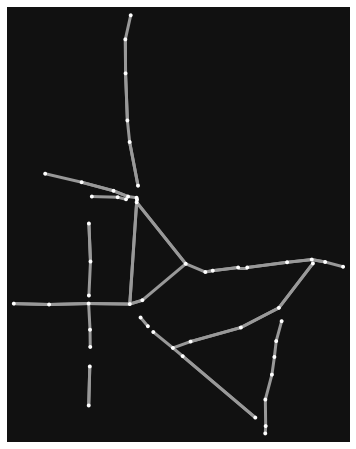

In [92]:
fig, ax = ox.plot_graph(subgraphs[2], node_size=15, edge_linewidth=3)

In [87]:
test = ox.graph_to_gdfs(subgraphs[2], nodes=False, edges=True)

In [ ]:
recon = nx.disjoint_union_all(subgraphs)
return ox.graph_to_gdfs(recon, nodes=True, edges=True)

In [ ]:
#join on matched_graph_edges_public to retrieve activity

# Match ROW data to map

In [72]:
row_df = pd.read_csv("data/row/row_bbox.csv")

In [73]:
nearest_edges, dists = ox.nearest_edges(G, row_df["longitude"], row_df["latitude"], return_dist=True, interpolate=metres_to_dist(INTERPOLATION_DIST_NEAREST_EDGE))

In [74]:
row_df["ne"] = nearest_edges
row_df["dist"] = dists

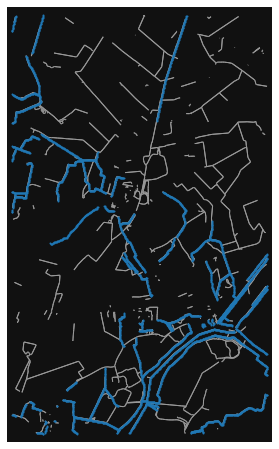

In [18]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(row_df["longitude"], row_df["latitude"], s=4, marker='.')
plt.show()

In [75]:
matched_row_df = threshold_on_col(row_df)

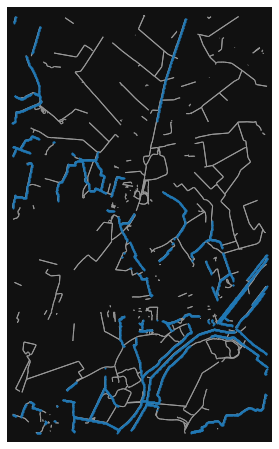

In [20]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(matched_row_df["longitude"], matched_row_df["latitude"], s=4, marker='.')
plt.show()

In [76]:
matched_graph_edges_row = match_nearest_edges(graph_edges, matched_row_df)

In [79]:
matched_graph_edges_row = matched_graph_edges_row \
                            .assign(row=matched_graph_edges_row["count"] > matched_graph_edges_row["length"] / THRESH_EDGE_MAX_POINT_SEPARATION_ROW_GPS) \
                            .drop(columns=["count", "tracks"])

In [80]:
matched_graph_edges_row = matched_graph_edges_row.loc[matched_graph_edges_row["row"]]

In [25]:
matched_graph_edges_row.to_file("analysis_saves/matched_graph_edges_row.shp")

<ipython-input-25-48ccfc5ec83f>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  matched_graph_edges_row.to_file("analysis_saves/matched_graph_edges_row.shp")


In [26]:
G_match_row = ox.graph_from_gdfs(graph_nodes, matched_graph_edges_row)

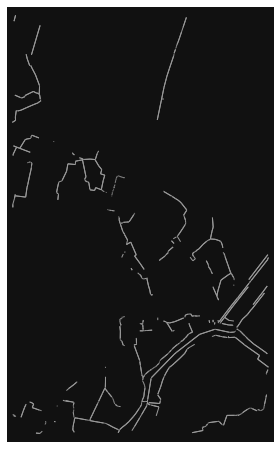

In [27]:
fig, ax = ox.plot_graph(G_match_row, node_size=0)

# Join GPS matched edges and ROW matched edges

In [51]:
matched_graph_edges_public = gpd.read_file("analysis_saves/matched_graph_edges_public.shp").set_index(["u","v","key"])
matched_graph_edges_row    = gpd.read_file("analysis_saves/matched_graph_edges_row.shp"   ).set_index(["u","v","key"])

In [52]:
df1, df2 = merge_on_edges(matched_graph_edges_public, matched_graph_edges_row, hows=["inner", "left_only"], del_cols=["count, tracks"])

df1["row"] = df1["row"] == 1
df2["row"] = df2["row"] == 1

In [53]:
public_row_df = pd.concat([df1, df2], axis=0).astype(graph_edges.dtypes.to_dict())

In [55]:
public_row_df["activity"] = raw_activity_to_percentage(public_row_df["activity"])

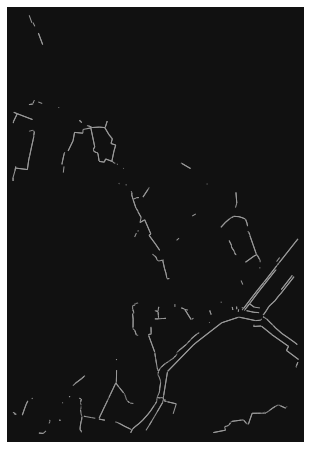

In [56]:
fig, ax = ox.plot_graph(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == True]), node_size=0)

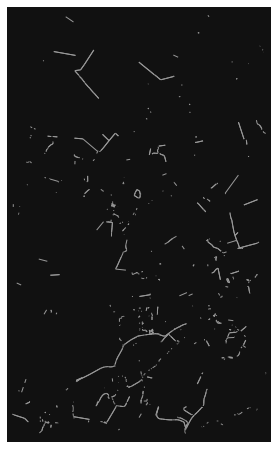

In [57]:
fig, ax = ox.plot_graph(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == False]), node_size=0)

In [58]:
ox.save_graphml(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == True]),  "output/G_busyrow.graphml")
ox.save_graphml(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == False]), "output/G_busynonrow.graphml")

In [131]:
def _thresh(x,t): return x[x<t]

(array([468., 126.,  59.,  24.,  11.,   9.,   3.,   4.,   0.,   1.]),
 array([0.03409072, 0.45687707, 0.87966342, 1.30244978, 1.72523613,
        2.14802249, 2.57080884, 2.9935952 , 3.41638155, 3.83916791,
        4.26195426]),
 <BarContainer object of 10 artists>)

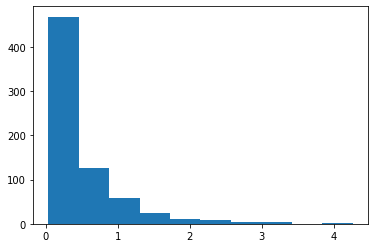

In [133]:
plt.hist(_thresh(df1["activity"].to_numpy(), 5))

(array([1049.,  228.,   82.,   29.,   17.,   10.,    8.,    6.,    2.,
           2.]),
 array([0.03341732, 0.52880333, 1.02418933, 1.51957533, 2.01496133,
        2.51034734, 3.00573334, 3.50111934, 3.99650535, 4.49189135,
        4.98727735]),
 <BarContainer object of 10 artists>)

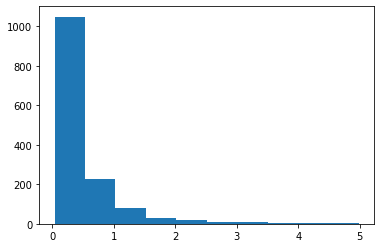

In [134]:
plt.hist(_thresh(df2["activity"].to_numpy(), 5))